In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import git
import math
import os
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import pacf
from pandas.plotting import autocorrelation_plot
from datetime import datetime
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import lightgbm as lgb
import statsmodels.tsa.stattools as ts

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

In [19]:
df_jhu = pd.read_csv(f"{homedir}/data/us/aggregate_jhu.csv")
# Get rid of the aggregate country data
df_jhu = df_jhu.drop([0])
df_jhu['FIPS'] = df_jhu['FIPS'].map(lambda f : str(f))
def alter(fips):
    if len(fips) == 4:
        return '0' + fips
    return fips
df_jhu['FIPS'] = df_jhu['FIPS'].map(alter)
df_jhu = df_jhu.set_index('FIPS')
df_jhu['fips'] = df_jhu.index.map(lambda s : int(s))
# fill out missing data
df_jhu.at['02158', 'Area in square miles - Land area'] = 19673
df_jhu.at['02158', 'Density per square mile of land area - Population'] = 0.44
df_jhu.at['46102', 'Area in square miles - Land area'] = 2097
df_jhu.at['46102', 'Density per square mile of land area - Population'] = 6.5

In [4]:
features = ['State', 'Area_Name','POP_ESTIMATE_2018', 'Area in square miles - Land area', 'Density per square mile of land area - Population', 'Total_Male', 'Total_Female', 'Total_age0to17', 
            'Total_age18to64','Total_age65plus', 'Active Physicians per 100000 Population 2018 (AAMC)', 'Active General Surgeons per 100000 Population 2018 (AAMC)',
           'Non-profit hospital beds per 1000 people (2019)', 'Employed_2018', 'Unemployment_rate_2018'
           , 'Total hospital beds per 1000 people (2019)', 'Total nurse practitioners (2019)',
           'Total Hospitals (2019)','fips']

In [5]:
# gets list of all fips numbers
def get_fips():
    Y = pd.read_csv(f"{homedir}/data/us/covid/deaths.csv")
    return set(Y.countyFIPS.values)
def get_date(datestr, formatstr='%Y-%m-%d'):
    return datetime.strptime(datestr, formatstr)

In [189]:
class CumDeathCounter():
    def __init__(self):
        self.cum_deaths = pd.read_csv(f"{homedir}/data/us/covid/deaths.csv")
        self.cum_deaths = self.cum_deaths.iloc[1:]
        fips_list = self.cum_deaths.countyFIPS.values
        
        self.cache = {}
        for fips in fips_list:
            self.cache[fips] = self.get_cum_deaths(fips)
    def get_cum_deaths(self, fips, clip_zeros=False):
        idx = self.cum_deaths.index[self.cum_deaths['countyFIPS'] == fips].values[0]
        county_deaths = self.cum_deaths.loc[self.cum_deaths['countyFIPS'] == fips]
        dates = pd.to_datetime(county_deaths.columns[4:].values).map(lambda dt : str(dt))
        X = np.array([(get_date(d[:10]) - get_date('2020-01-01')).days for d in dates])
        y = []
        for i in range(4, len(county_deaths.columns)):
            y.append(county_deaths.loc[idx,county_deaths.columns[i]])
        if not clip_zeros:
            return X, y
        for i in range(len(y)):
            if y[i] != 0:
                return X[i:], y[i:]
    def getY(self, fips):
        return self.cache[fips]
class CumCaseCounter():
    def __init__(self):
        self.cum_cases = pd.read_csv(f"{homedir}/data/us/covid/confirmed_cases.csv")
        self.cum_cases = self.cum_cases.iloc[1:]
        self.cum_cases = self.cum_cases.iloc[:, :-1]
        
        fips_list = self.cum_cases.countyFIPS.values
        
        self.cache = {}
        for fips in fips_list:
            self.cache[fips] = self.get_cum_cases(fips)
        
    def get_cum_cases(self, fips,clip_zeros=False):
        idx = self.cum_cases.index[self.cum_cases['countyFIPS'] == fips].values[0]
        county_cases = self.cum_cases.loc[self.cum_cases['countyFIPS'] == fips]
        dates = pd.to_datetime(county_cases.columns[4:].values).map(lambda dt : str(dt))
        X = np.array([(get_date(d[:10]) - get_date('2020-01-01')).days for d in dates])
        y = []
        for i in range(4, len(county_cases.columns)):
            y.append(county_cases.loc[idx,county_cases.columns[i]])
        if not clip_zeros:
            return X, y
        for i in range(len(y)):
            if y[i] != 0:
                return X[i:], y[i:]
    def getY(self, fips):
        return self.cache[fips]
    
class DeltaCounter:
    def __init__(self, counter):
        self.counter = counter
    def getY(self, fips):
        X, y = self.counter.getY(fips)
        y_true = [y[0]]
        for i in range(1, len(y)):
            y_true.append(y[i] - y[i-1])
        return X, y_true
class RatioCounter:
    def __init__(self, counter):
        self.counter = counter
    def getY(self, state, avg_period=5):
        X_raw, y_raw = self.counter.getY(state)
        y = []
        running_sum = 0.0
        running_time = 0
        for i in range(len(X_raw)):
            if y_raw[i] == 0:
                y.append(0)
            elif running_sum == 0:
                y.append(1) # if this is the first case we define the signal as 1
            else:
                avg = running_sum/running_time
                y.append(y_raw[i]/avg)
            if running_time == avg_period:
                running_sum = running_sum + y_raw[i] - y_raw[i - avg_period]
            else:
                running_sum = running_sum + y_raw[i]
                running_time = running_time + 1    
            if running_sum == 0:
                running_time = 1
        return (X_raw, np.array(y))
class MobilityCounter:
    def __init__(self, states=False):
        data_dir = f'{homedir}/data/us/mobility'
        df = pd.read_csv(os.path.join(data_dir, 'DL-us-mobility-daterow.csv'))
        counties = df[df['admin_level'] == 2]
        self.fips_list = np.unique(counties.fips.map(lambda f: int(f)))
        self.data = {}
        
        for fips in fips_list:
            data_dir = f'{homedir}/data/us/mobility'
            df = pd.read_csv(os.path.join(data_dir, 'DL-us-mobility-daterow.csv'))
            counties = df[df['admin_level'] == 2]
            counties['fips'] = counties['fips'].map(lambda f: int(f))
            county_data = counties[counties['fips'] == 36061]
            county_data['date'] = county_data['date'].map(lambda l: (get_date(l) - get_date('2020-01-01')).days)
            self.data[fips] = county_data['date'], county_data['m50']
    def getY(self, fips):
        if fips not in self.fips_list:
            raise ValueError('No Mobility data for this fips')
        return self.data[fips]

In [190]:
cum_death_counter = CumDeathCounter()
cum_case_counter = CumCaseCounter()
delta_death_counter = DeltaCounter(cum_death_counter)
delta_case_counter = DeltaCounter(cum_case_counter)
delta_death_ratio_counter = RatioCounter(delta_death_counter)
delta_case_ratio_counter = RatioCounter(delta_case_counter)

In [191]:
mobility_counter = MobilityCounter()

NameError: name 'fips_list' is not defined

In [62]:
def split_fips(counter, min_thresh=10):
    fips_list = get_fips()
    large_fips = []
    small_fips = []
    for fips in fips_list:
        X,y = counter.getY(fips)
        if y[-1] > min_thresh:
            large_fips.append(fips)
        else:
            small_fips.append(fips)
    return large_fips, small_fips
df_jhu_states = df_jhu[df_jhu.fips % 1000 == 0]

def state_to_fip(state_abr):
    # Converts state abbreviation to FIPS code
    return df_jhu_states.fips[df_jhu_states.State == state_abr].values[0]

In [71]:
df_tests = pd.read_csv(f"{homedir}/data/us/covid/daily_state_tests.csv")
useful_cols = ['date', 'state', 'fips', 'positive','negative',
               'hospitalizedCurrently','inIcuCurrently','onVentilatorCurrently','recovered']
good_states = []
for state in df_tests['state'].unique():
    try:
        state_to_fip(state)
        good_states.append(state)
    except:
        print(state)
df_tests = df_tests.iloc[np.where(df_tests.state.map(lambda state : state in good_states))]
df_tests['state_fips'] = df_tests['state'].map(state_to_fip)
df_tests['fips'] = df_tests['state_fips'] + df_tests['fips']
df_tests = df_tests[useful_cols]
print(np.sum(df_tests.isna()))
df_tests.head()

AS
GU
MP
VI
date                        0
state                       0
fips                        0
positive                    0
negative                  140
hospitalizedCurrently    1960
inIcuCurrently           2523
onVentilatorCurrently    2628
recovered                2160
dtype: int64


,date,state,fips,positive,negative,hospitalizedCurrently,inIcuCurrently,onVentilatorCurrently,recovered
0,20200502,AK,2002,365.0,21034.0,10.0,NaN,NaN,261.0
1,20200502,AL,1001,7434.0,84775.0,NaN,NaN,NaN,NaN
2,20200502,AR,5005,3372.0,48210.0,95.0,NaN,20.0,1987.0
4,20200502,AZ,4004,8364.0,69633.0,718.0,291.0,198.0,1565.0
5,20200502,CA,6006,52197.0,634606.0,4722.0,1433.0,NaN,NaN


In [144]:
def get_XY(features, delta_y, look_back_y, y_generator, fips_list=get_fips(), moving_window=True):
    df = df_jhu[features]
    df = df[df.fips % 1000 != 0] # remove aggregate states
    df = df[df.State != 'PR']   # peurto rico has some weird data...
    df = df[df.POP_ESTIMATE_2018 > 1000] # restrict to large counties since getting lots of data is difficult
    df['cases'] = df['fips'].map(lambda fip: 0)

    col_names = []
    for i in range(look_back_y):
        col_name = "y at t = -%d" %i
        col_names.append(col_name)
        df[col_name] = np.zeros(n)
    X = []
    Y = []
    for fips in tqdm(df.index):
        if int(fips) not in fips_list:
            continue
        base = df.loc[fips].values
        _, cum_cases = cum_case_counter.getY(int(fips))
        try:
            t, ys = y_generator.getY(int(fips))
        except KeyError:
            continue
        if len(ys) == 0:
            X.append(base)
            Y.append(0)
            continue
        for j in range(-1, -len(ys), -1):
            base = df.loc[fips].values
            if j - delta_y >= -len(cum_cases):
                base[-look_back_y - 1] = cum_cases[j - delta_y]
            Y.append(ys[j])
            for i in range(look_back_y):
                if j - delta_y - i >= -len(ys):
                    base[-look_back_y + i] = ys[j - delta_y - i]
            X.append(base)
            if not moving_window:
                break
    df_new = pd.DataFrame(X, columns = df.columns)
    df_new['target'] = Y
    return df_new

def Rsquare(pred, actual):   
    return np.corrcoef(pred, actual)[0,1]**2

In [145]:
df_new = get_XY(features, 5, 5, delta_death_counter, moving_window=False)

In [106]:
X = df_new.iloc[:,2:-1]
y = df_new['target'].values
train_num = int(y.shape[0] * 0.66)

X_test = X.iloc[train_num:]
y_test = y[train_num:]
X_train = X.iloc[:train_num]
y_train = y[:train_num]

In [107]:
normal_model = LinearRegression().fit(X_train.values, y_train)
print("R^2 (in sample): %f" % normal_model.score(X_train,y_train))
print("R^2 (in sample): %f" % normal_model.score(X_test,y_test))

R^2 (in sample): 0.928208
R^2 (in sample): 0.142167


In [123]:
ridge_model = Ridge(alpha=200)
ridge_model.fit(X_train.values, y_train)
print("R^2 (in sample): %f" % ridge_model.score(X_train,y_train))
print("R^2 (in sample): %f" % ridge_model.score(X_test,y_test))

R^2 (in sample): 0.928121
R^2 (in sample): 0.145038


In [121]:
lasso_model = Lasso(alpha=0)
lasso_model.fit(X_train.values, y_train)
print("R^2 (in sample): %f" % lasso_model.score(X_train,y_train))
print("R^2 (in sample): %f" % lasso_model.score(X_test,y_test))

R^2 (in sample): 0.927479
R^2 (in sample): 0.149700


/home/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/home/sean/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/sean/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1832.327438890261, tolerance: 5.053206246949733
  positive)


[1]	valid_0's l2: 1.29079
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l2: 1.2209
[3]	valid_0's l2: 1.16359
[4]	valid_0's l2: 1.11534
[5]	valid_0's l2: 1.08123
[6]	valid_0's l2: 1.03714
[7]	valid_0's l2: 0.998859
[8]	valid_0's l2: 0.985461
[9]	valid_0's l2: 0.963344
[10]	valid_0's l2: 0.954531
[11]	valid_0's l2: 0.93526
[12]	valid_0's l2: 0.917562
[13]	valid_0's l2: 0.907525
[14]	valid_0's l2: 0.88527
[15]	valid_0's l2: 0.870591
[16]	valid_0's l2: 0.865042
[17]	valid_0's l2: 0.846859
[18]	valid_0's l2: 0.855047
[19]	valid_0's l2: 0.856647
[20]	valid_0's l2: 0.853776
[21]	valid_0's l2: 0.844075
[22]	valid_0's l2: 0.840073
[23]	valid_0's l2: 0.848938
[24]	valid_0's l2: 0.847332
[25]	valid_0's l2: 0.84862
[26]	valid_0's l2: 0.868584
[27]	valid_0's l2: 0.865241
[28]	valid_0's l2: 0.862191
[29]	valid_0's l2: 0.88552
[30]	valid_0's l2: 0.881107
[31]	valid_0's l2: 0.907316
[32]	valid_0's l2: 0.90394
[33]	valid_0's l2: 0.932096
[34]	valid_0's l2: 0.928402
[35]	val

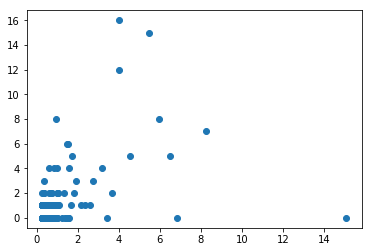

In [127]:
gbm = lgb.LGBMRegressor(num_leaves=5,
                        learning_rate=0.05,
                        n_estimators=250);
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l2',
        early_stopping_rounds=20);
pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration_)
print("R squared (in sample) is %f" % Rsquare(pred_train, y_train))
pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print("R squared (out sample) is %f" % Rsquare(pred_test, y_test))
plt.scatter(pred_test, y_test)

## Splitting

In [150]:
large_fips, small_fips = split_fips(cum_death_counter,min_thresh=50)
df_new = get_XY(features, 5, 5, delta_death_counter, fips_list=large_fips, moving_window=True)

(array([1.3916e+04, 1.0100e+02, 1.3000e+01, 3.0000e+00, 3.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ -35. ,   70.7,  176.4,  282.1,  387.8,  493.5,  599.2,  704.9,
         810.6,  916.3, 1022. ]),
 <a list of 10 Patch objects>)

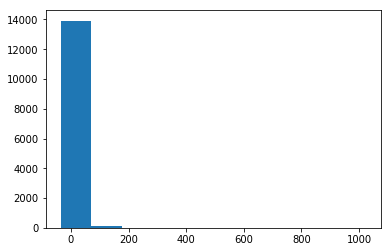

In [151]:
X = df_new.iloc[:,2:-1]
y = df_new['target'].values
train_num = int(y.shape[0] * 0.66)

X_test = X.iloc[train_num:]
y_test = y[train_num:]
X_train = X.iloc[:train_num]
y_train = y[:train_num]
plt.hist(y)

In [156]:
normal_model = LinearRegression().fit(X_train.values, y_train)
print("Ordinary Least Squares")
print("R^2 (in sample): %f" % normal_model.score(X_train,y_train))
print("R^2 (in sample): %f" % normal_model.score(X_test,y_test))
ridge_model = Ridge(alpha=2000)
ridge_model.fit(X_train.values, y_train)
print("Ridge Model")
print("R^2 (in sample): %f" % ridge_model.score(X_train,y_train))
print("R^2 (in sample): %f" % ridge_model.score(X_test,y_test))
lasso_model = Lasso(alpha=1)
lasso_model.fit(X_train.values, y_train)
print("Lasso Model")
print("R^2 (in sample): %f" % lasso_model.score(X_train,y_train))
print("R^2 (in sample): %f" % lasso_model.score(X_test,y_test))

Ordinary Least Squares
R^2 (in sample): 0.645696
R^2 (in sample): 0.369324
Ridge Model
R^2 (in sample): 0.645537
R^2 (in sample): 0.369886
Lasso Model
R^2 (in sample): 0.643375
R^2 (in sample): 0.373100


/home/sean/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144476.26143820083, tolerance: 77.37248069077172
  positive)


[1]	valid_0's l2: 947.201
Training until validation scores don't improve for 120 rounds
[2]	valid_0's l2: 931.971
[3]	valid_0's l2: 917.123
[4]	valid_0's l2: 903.618
[5]	valid_0's l2: 891.253
[6]	valid_0's l2: 879.487
[7]	valid_0's l2: 868.763
[8]	valid_0's l2: 857.312
[9]	valid_0's l2: 848.12
[10]	valid_0's l2: 839.611
[11]	valid_0's l2: 831.25
[12]	valid_0's l2: 822.147
[13]	valid_0's l2: 813.772
[14]	valid_0's l2: 804.724
[15]	valid_0's l2: 797.801
[16]	valid_0's l2: 790.036
[17]	valid_0's l2: 782.643
[18]	valid_0's l2: 775.172
[19]	valid_0's l2: 769.31
[20]	valid_0's l2: 763.221
[21]	valid_0's l2: 756.244
[22]	valid_0's l2: 751.792
[23]	valid_0's l2: 747.752
[24]	valid_0's l2: 742.306
[25]	valid_0's l2: 736.531
[26]	valid_0's l2: 732.859
[27]	valid_0's l2: 728.911
[28]	valid_0's l2: 725.674
[29]	valid_0's l2: 722.734
[30]	valid_0's l2: 718.144
[31]	valid_0's l2: 715.279
[32]	valid_0's l2: 712.678
[33]	valid_0's l2: 709.287
[34]	valid_0's l2: 706.056
[35]	valid_0's l2: 703.706
[36]	

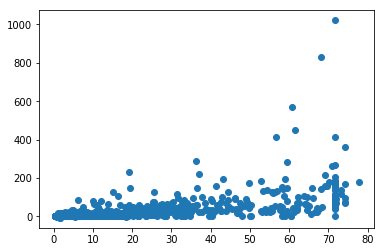

In [161]:
gbm = lgb.LGBMRegressor(num_leaves=5,
                        learning_rate=0.05,
                        n_estimators=250);
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l2',
        early_stopping_rounds=120);
pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration_)
print("R squared (in sample) is %f" % Rsquare(pred_train, y_train))
pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print("R squared (out sample) is %f" % Rsquare(pred_test, y_test))
plt.scatter(pred_test, y_test)

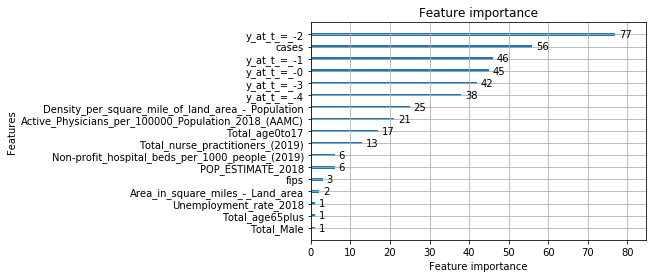

In [162]:
lgb.plot_importance(gbm)

In [165]:
import_feat = ['y at t = -2','cases','y at t = -0','Density per square mile of land area - Population','Active Physicians per 100000 Population 2018 (AAMC)']